In [53]:
%load_ext autoreload
%autoreload 2
from rxnutils import *
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import os
import ast
from rxnmapper import RXNMapper
from chemUtils.synthesis import reaction
import json
from IPython.display import display
from collections import OrderedDict
from prettytable import PrettyTable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
with open('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/RXN_SMARTS_CONSTANTS.json', 'r') as f:
    reaction_smarts = json.load(f)
# Pretty print the JSON content
pretty_json = json.dumps(reaction_smarts, indent=4)
print(pretty_json)

{
    "Amidation": "[#6:1](=[#8:2])-[#8;H1].[#7&X3;!$(NC=*);!$(NS):3]>>[#6:1](=[#8:2])-[#7X3:3]",
    "Amide_schotten-baumann": "[#7;H2,H1:3].[#6:1](=[#8:2])-[#17]>>[#6:1](=[#8:2])-[#7:3]",
    "Reductive_amination": "[#6:2](=[#8])(-[#6:1]).[#7;H2,H1:3]>>[#6:2](-[#6:1])-[#7:3]",
    "N-nucleophilic_aromatic_substitution": "[#6:3]-[#7;H3,H2,H1:2].[c:1]-[F,Cl,Br,I]>>[#6:3]-[#7:2]-[c:1]",
    "Sp2-sp2_Suzuki_coupling": "[#6X3:1]-[F,Cl,Br,I].[#6X3:2]-[B](-[O])(-[O])>>[#6X3:1]-[#6X3:2]",
    "Formation_of_urea_from_two_amines": "[N&X3;H2,H1;!$(NC=O);!$(NS):3].[N&X3;H2,H1;!$(NC=O);!$(NS):4]>>[#7&X3:3]-[#6](=[#8])-[#7&X3:4]",
    "Sulfonamide_Schotten-Baumann_with_amine_(intermolecular)": "[#16X4:1](=[OX1:2])(=[OX1:3])([#6,#7:4])[#17,#9].[#7&X3;H2,H1;!$(NC=O);!$(NS):5]>>[#16X4:1](=[OX1:2])(=[OX1:3])([#6,#7:4])-[#7:5]",
    "Buchwald-Hartwig_amination": "[ar:1]-[Cl,Br,I].[#7&X3;H2,H1;!$(NC=*);!$(NS);!$(NN):7]>>[ar:1]-[N:7]",
    "Nucleophilic_substitution_with_thiol": "[Cl,Br]-[C;H2,H1;+0:1].[

In [61]:
reaction_smarts['Sp3-sp2_Suzuki_coupling']

'[#6X3:1]-[F,Cl,Br,I].[CX4:2]-[B](-[O])(-[O])>>[#6X3:1]-[CX4:2]'

In [59]:
# Need to check that all reactions in df1 with the name in constants works for the smarts
def check_smarts(df, name_to_check):
    smarts_dict = {}
    for i in range(len(df)):
        row = df.iloc[i]
        for j in range(row.num_steps): # perform for each step in route
            name = ast.literal_eval(row.rxn_order_first_to_last)[j]
            name = name.replace(' ', '_')
            reactants = ast.literal_eval(row.reactants)[j]
            if j < 1:
                products = ast.literal_eval(row.reactants)[j-1]
                # if len(poss_prod) == 1:
                #     product = poss_prod[0]
                # else:
                #     product1 = poss_prod[0]
                #     product2 = poss_prod[1]
                #     if Chem.MolFromSmiles(product1).GetNumAtoms() > Chem.MolFromSmiles(product2).GetNumAtoms():
                #         product = product1
                #     else:
                #         product = product2
            else:
                products = [row.smiles]
            if name == name_to_check:
                smarts_name = name.replace(' ', '_')
                mapping = reaction_smarts[smarts_name]
                print('ROW:', i)
                print(reactants)
                if Chem.MolFromSmiles(reactants[0]).GetNumAtoms() == 1:
                    if len(reactants) == 2:
                        if Chem.MolFromSmiles(reactants[1]).GetNumAtoms() == 1:
                            print('ONE ATOM REACTANT')
                            continue
                    else:
                        print('ONE ATOM REACTANT')
                        continue
                outcome = reaction.check_rxn_template_works(mapping, reactants, products, verbose=True)
                print(outcome)
                if outcome[0] != 1:
                    print('FAILED')
                    print(row)
                    print('REACTANT(S) BELOW:')
                    display(Chem.MolFromSmiles(reactants[0]))
                    if len(reactants) == 2:
                        display(Chem.MolFromSmiles(reactants[1]))
                    if outcome[0] == 0:
                        print('THE PREDICTED PRODUCT(S) IS/ARE WRONG')
                        for i in outcome[1]:
                            display(Chem.MolFromSmiles(i))
                        print('PROPER PRODUCT IS ONE OF THE BELOW')
                        for i in products:
                            display(Chem.MolFromSmiles(i))
                    else:
                        print('THE PREDICTED PRODUCT(S) IS/ARE RIGHT')
                        for i in outcome[1]:
                            display(Chem.MolFromSmiles(i))
                        print(outcome[0])
                    break

# CHECKING TWO STEP

ROW: 0
('Cc1cc2c(cc1NC(=O)NCCB1OC(C)(C)C(C)(C)O1)OCO2', 'Brc1nnc2ccccn12')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product with Tanimoto similarity of 1.0.
outcome of second combo ['Cc1cc2c(cc1NC(=O)NCCc1nnc3ccccn13)OCO2', 'Cc1cc2c(cc1NC(=O)NCCc1nnc3ccccn13)OCO2']
(1, ['Cc1cc2c(cc1NC(=O)NCCc1nnc3ccccn13)OCO2', 'Cc1cc2c(cc1NC(=O)NCCc1nnc3ccccn13)OCO2'])
ROW: 1
('Cc1ccc(I)cc1', 'CC1(C)OB(CCS(=O)(=O)NCc2nnc3ccccn23)OC1(C)C')
The reaction SMARTS is applicable and produces the expected product with Tanimoto similarity of 1.0.
outcome of first combo ['Cc1ccc(CCS(=O)(=O)NCc2nnc3ccccn23)cc1', 'Cc1ccc(CCS(=O)(=O)NCc2nnc3ccccn23)cc1']
The reaction SMARTS is not applicable to the provided reactants.
outcome of second combo []
(1, ['Cc1ccc(CCS(=O)(=O)NCc2nnc3ccccn23)cc1', 'Cc1ccc(CCS(=O)(=O)NCc2nnc3ccccn23)cc1'])
ROW: 4
('CCN(c1ccc2c(c1)OCO2)S(=O)(=O)c1ccc2nnc(I)n2c1', 'CCB(O)O')
The reac

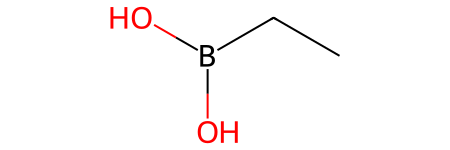

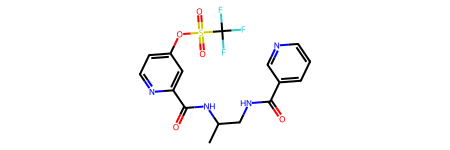

THE PREDICTED PRODUCT(S) IS/ARE WRONG
PROPER PRODUCT IS ONE OF THE BELOW


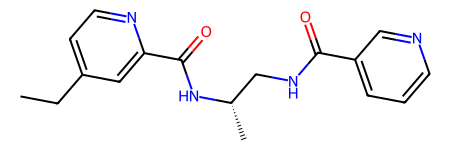

ROW: 201
('CC1(C)OB(C2CC(NC(=O)Cc3ccc4c(c3)OCO4)C2)OC1(C)C', 'Brc1ccon1')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product with Tanimoto similarity of 1.0.
outcome of second combo ['O=C(Cc1ccc2c(c1)OCO2)NC1CC(c2ccon2)C1', 'O=C(Cc1ccc2c(c1)OCO2)NC1CC(c2ccon2)C1']
(1, ['O=C(Cc1ccc2c(c1)OCO2)NC1CC(c2ccon2)C1', 'O=C(Cc1ccc2c(c1)OCO2)NC1CC(c2ccon2)C1'])
ROW: 212
('O=C(CCB(O)O)NC1(c2ccccn2)CC1', 'Ic1ccc2c(c1)OCO2')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product with Tanimoto similarity of 1.0.
outcome of second combo ['O=C(CCc1ccc2c(c1)OCO2)NC1(c2ccccn2)CC1', 'O=C(CCc1ccc2c(c1)OCO2)NC1(c2ccccn2)CC1']
(1, ['O=C(CCc1ccc2c(c1)OCO2)NC1(c2ccccn2)CC1', 'O=C(CCc1ccc2c(c1)OCO2)NC1(c2ccccn2)CC1'])
ROW: 222
('Ic1cccnc1', 'CC1(C)OB(C2CCN(C(=O)NCc3ccc4c(c3)OCO4)CC2)OC1(C)C')
The reacti

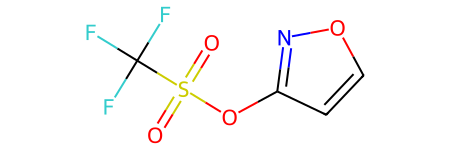

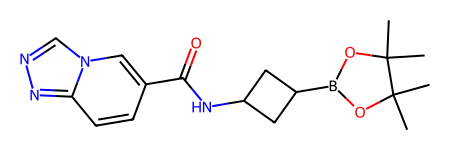

THE PREDICTED PRODUCT(S) IS/ARE WRONG
PROPER PRODUCT IS ONE OF THE BELOW


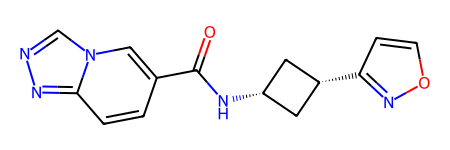

ROW: 249
('OB(O)C1CC1', 'CC(CNC(=O)c1cccnc1)CNC(=O)c1cccnc1I')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product with Tanimoto similarity of 1.0.
outcome of second combo ['CC(CNC(=O)c1cccnc1)CNC(=O)c1cccnc1C1CC1', 'CC(CNC(=O)c1cccnc1)CNC(=O)c1cccnc1C1CC1']
(1, ['CC(CNC(=O)c1cccnc1)CNC(=O)c1cccnc1C1CC1', 'CC(CNC(=O)c1cccnc1)CNC(=O)c1cccnc1C1CC1'])
ROW: 263
('CC(NC(=O)Nc1ccc(Br)cn1)C(=O)N1CCCCC1', 'CC(C)(C)B(O)O')
The reaction SMARTS is applicable and produces the expected product with Tanimoto similarity of 1.0.
outcome of first combo ['CC(NC(=O)Nc1ccc(C(C)(C)C)cn1)C(=O)N1CCCCC1', 'CC(NC(=O)Nc1ccc(C(C)(C)C)cn1)C(=O)N1CCCCC1']
The reaction SMARTS is not applicable to the provided reactants.
outcome of second combo []
(1, ['CC(NC(=O)Nc1ccc(C(C)(C)C)cn1)C(=O)N1CCCCC1', 'CC(NC(=O)Nc1ccc(C(C)(C)C)cn1)C(=O)N1CCCCC1'])
ROW: 270
('O=C(OCCNC(=O)N1CCCCC1)c1ncccc1I', 'CC(C)(C)B1OC(C)(C)C(C)

In [60]:
name_to_check = 'Sp3-sp2_Suzuki_coupling'
os.chdir('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/routes_data')
df = pd.read_csv('D68EV3CPROA_enumeration_oct10_first_route_2_step_FORWARD.csv', index_col=0)
#df = pd.read_csv('D68EV3CPROA_enumeration_oct10_first_route_1_step.csv')
#reaction_smarts[name_to_check] = "[Cl,Br,I]-[#6:1].[#6;+0:2]-[OH;D1;+0:3]>>[#6X4:1]-[O;H0;D2;+0:3]-[#6X4+0:2]"
# with open('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/RXN_SMARTS_CONSTANTS.json', 'w') as f:
#     json.dump(reaction_smarts, f)
    
check_smarts(df, name_to_check)

In [13]:
reaction_smarts

{'Amidation': '[#6:1](=[#8:2])-[#8;H1].[#7&X3;!$(NC=*);!$(NS):3]>>[#6:1](=[#8:2])-[#7X3:3]',
 'Amide_schotten-baumann': '[#7;H2,H1:3].[#6:1](=[#8:2])-[#17]>>[#6:1](=[#8:2])-[#7:3]',
 'Reductive_amination': '[#6:2](=[#8])(-[#6:1]).[#7;H2,H1:3]>>[#6:2](-[#6:1])-[#7:3]',
 'N-nucleophilic_aromatic_substitution': '[#6:3]-[#7;H3,H2,H1:2].[c:1]-[F,Cl,Br,I]>>[#6:3]-[#7:2]-[c:1]',
 'Sp2-sp2_Suzuki_coupling': '[#6X3:1]-[F,Cl,Br,I].[#6X3:2]-[B](-[O])(-[O])>>[#6X3:1]-[#6X3:2]',
 'Formation_of_urea_from_two_amines': '[N&X3;H2,H1;!$(NC=O);!$(NS):3].[N&X3;H2,H1;!$(NC=O);!$(NS):4]>>[#7&X3:3]-[#6](=[#8])-[#7&X3:4]',
 'Sulfonamide_Schotten-Baumann_with_amine_(intermolecular)': '[#16X4:1](=[OX1:2])(=[OX1:3])([#6,#7:4])[#17,#9].[#7&X3;H2,H1;!$(NC=O);!$(NS):5]>>[#16X4:1](=[OX1:2])(=[OX1:3])([#6,#7:4])-[#7:5]',
 'Buchwald-Hartwig_amination': '[ar:1]-[Cl,Br,I].[#7&X3;H2,H1;!$(NC=*);!$(NS);!$(NN):7]>>[ar:1]-[N:7]',
 'Nucleophilic_substitution_with_thiol': '[Cl,Br]-[C;H2,H1;+0:1].[SH;+0:2]>>[S&X2;H0;D2;+0:2]-[

In [7]:
# Look at already created smarts patterns
with open('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/routes_data/all_single_step_max_smarts.json', 'r') as f:
    smarts = json.load(f)
smarts

{'Formation of urea from two amines': [['[C:1]-[NH2;D1;+0:2].[NH2;D1;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c;H0;D3;+0:8](:[cH;D2;+0:9]:[c:10]:1)-[O;H0;D2;+0:11]-[CH2;D2;+0:12]-[#8:13]-2>>[C:1]-[NH;D2;+0:2]-[C;H0;D3;+0:8](=[O;H0;D1;+0:11])-[NH;D2;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c:14](:[cH;D2;+0:9]:[c:10]:1)-[#8:15]-[CH2;D2;+0:12]-[#8:13]-2',
   2],
  ['[C:1]-[NH2;D1;+0:2].[NH2;D1;+0:3]-[C:4]-[c:5]1:[c:6]:[c:7]:[c;H0;D3;+0:8]2:[c;H0;D3;+0:9](:[cH;D2;+0:10]:1)-[O;H0;D2;+0:11]-[CH2;D2;+0:12]-[#8:13]-2>>[C:1]-[NH;D2;+0:2]-[C;H0;D3;+0:9](=[O;H0;D1;+0:11])-[NH;D2;+0:3]-[C:4]-[c:5]1:[c:6]:[c:7]:[c;H0;D3;+0:8]2:[c:14](:[cH;D2;+0:10]:1)-[#8:15]-[CH2;D2;+0:12]-[#8:13]-2',
   2],
  ['[C:1]-[NH2;D1;+0:2].[NH2;D1;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c;H0;D3;+0:8](:[cH;D2;+0:9]:[c:10]:1)-[O;H0;D2;+0:11]-[CH2;D2;+0:12]-[#8:13]-2>>[C:1]-[NH;D2;+0:2]-[C;H0;D3;+0:8](=[O;H0;D1;+0:11])-[NH;D2;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c:14](:[cH;D2;+0:9]:[c:10]:1)-[#8:15]-[CH2;D2;+0:12]-[

In [34]:
smarts['Alkene hydrogenation (unconjugated)']

KeyError: 'Alkene hydrogenation (unconjugated)'

In [27]:
test = AllChem.ReactionFromSmarts('[Cl,O=S]>>[Cl,O=S(=O)(C(F)(F)F)]')
print(test)

ValueError: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [Cl,O=S]